In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

2023-08-24 14:10:15.466556: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-24 14:10:15.515773: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-24 14:10:15.516900: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-24 14:10:16.377147: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/apakiman/Projects/dsr-b35/dsr-cv/envs/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [58]:
tf.keras.backend.clear_session()

class AutoEncoder(tf.keras.Model):

    def __init__(self, latent_dim):        # cunstructor
        super().__init__()

        self.latent_dim = latent_dim 

        # Todo: Encoder 
        self.encoder_reshape = tf.keras.layers.Reshape((784,))
        self.encoder_fc1 = tf.keras.layers.Dense(256, activation="relu")
        self.encoder_fc2 = tf.keras.layers.Dense(latent_dim, activation="relu")
        

        # Todo: Decoder
        self.decoder_fc1 = tf.keras.layers.Dense(256, activation="relu")
        self.decoder_fc2 = tf.keras.layers.Dense(784, activation="sigmoid")
        self.decoder_reshape = tf.keras.layers.Reshape((28, 28, 1))

        self._build_graph()

    def _build_graph(self):
        input_shape = (28, 28, 1)
        self.build((None,) + input_shape)
        inputs = tf.keras.Input(shape=input_shape)
        _ = self.call(inputs)

    def call(self, x):

        z = self.encode(x)
        y = self.decode(z)

        return y
    
    def encode(self, x):

        z = self.encoder_reshape(x)
        z = self.encoder_fc1(z)
        z = self.encoder_fc2(z)
        return z
    

    def decode(self, z):

        y = self.decoder_fc1(z)
        y = self.decoder_fc2(y)
        y = self.decoder_reshape(y)
        return y


autoencoder =AutoEncoder(32)
autoencoder.summary()
print(autoencoder.latent_dim)
print(autoencoder.encoder_reshape)

# prediciton = autoencoder.predict(np.random.random((1, 28, 28,1)))

autoencoder.compile(
    optimizer='rmsprop',
    loss="binary_crossentropy",

)

Model: "auto_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 256)               200960    
                                                                 
 dense_1 (Dense)             (None, 32)                8224      
                                                                 
 dense_2 (Dense)             (None, 256)               8448      
                                                                 
 dense_3 (Dense)             (None, 784)               201488    
                                                                 
 reshape_1 (Reshape)         (None, 28, 28, 1)         0         
                                                                 
Total params: 419120 (1.60 MB)
Trainable params: 41912

In [76]:
mnist_train_original, mnist_validate_original, mnist_test_original = tfds.load(
    "mnist",
    split=["train", "test[:50%]", "test[50%:]"],
    as_supervised=True
)

In [66]:
def encode(image):
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image, image

mnist_train = mnist_train_original.map(lambda image, _: encode(image)).cache().shuffle(6000)
mnist_validate = mnist_validate_original.map(lambda image, _: encode(image)).cache()
mnist_test  = mnist_test_original.map(lambda image, _: encode(image)).cache()

2023-08-24 15:44:24.964574: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


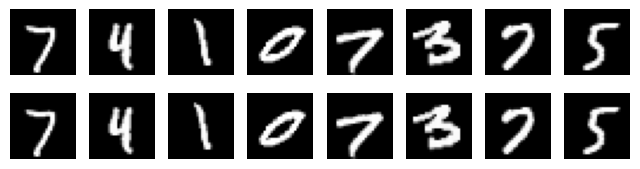

In [67]:
def render_dataset():
    index=1
    plt.figure(figsize=(8,2))
    for image_in, image_out in mnist_train.take(8):
        plt.subplot(2, 8, index)
        plt.axis("off")
        plt.imshow(image_in, cmap="gray")

        plt.subplot(2, 8, index+8)
        plt.axis("off")
        plt.imshow(image_out, cmap="gray")

        index+=1

render_dataset()

1/1 [==============================] - 0s 15ms/step


2023-08-24 15:26:34.528535: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-08-24 15:26:34.528634: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


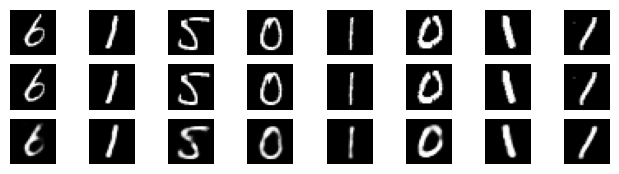

In [48]:
def render_predictions():
    index=1
    plt.figure(figsize=(8,2))
    for image_in, image_out in mnist_test.take(8):
        plt.subplot(3, 8, index)
        plt.axis("off")
        plt.imshow(image_in, cmap="gray")

        plt.subplot(3, 8, index+8)
        plt.axis("off")
        plt.imshow(image_in, cmap="gray")

        prediction = autoencoder.predict(image_in.numpy().reshape(1, 28, 28, 1))[0]
        plt.subplot(3, 8, index+16)
        plt.axis("off")
        plt.imshow(prediction, cmap="gray")

        index+=1

render_predictions()

In [45]:
_ = autoencoder.fit(
    mnist_train.batch(256),
    epochs=50,
    validation_data=mnist_validate.batch(256)
)

Epoch 1/50
235/235 [==============================] - 4s 13ms/step - loss: 0.2726 - val_loss: 0.2125
Epoch 2/50
235/235 [==============================] - 2s 8ms/step - loss: 0.1897 - val_loss: 0.1729
Epoch 3/50
235/235 [==============================] - 2s 9ms/step - loss: 0.1635 - val_loss: 0.1581
Epoch 4/50
235/235 [==============================] - 2s 8ms/step - loss: 0.1469 - val_loss: 0.1384
Epoch 5/50
235/235 [==============================] - 2s 8ms/step - loss: 0.1367 - val_loss: 0.1314
Epoch 6/50
235/235 [==============================] - 2s 8ms/step - loss: 0.1301 - val_loss: 0.1264
Epoch 7/50
235/235 [==============================] - 2s 8ms/step - loss: 0.1252 - val_loss: 0.1197
Epoch 8/50
235/235 [==============================] - 2s 9ms/step - loss: 0.1209 - val_loss: 0.1191
Epoch 9/50
235/235 [==============================] - 2s 8ms/step - loss: 0.1170 - val_loss: 0.1139
Epoch 10/50
235/235 [==============================] - 2s 8ms/step - loss: 0.1141 - val_loss: 0.109

1/1 [==============================] - 0s 16ms/step


2023-08-24 15:29:28.941620: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-08-24 15:29:28.941708: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


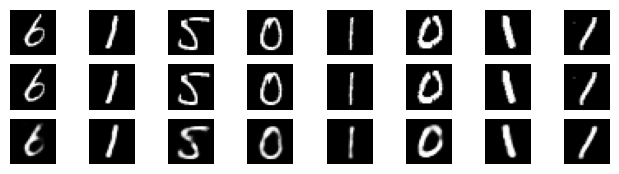

In [49]:
render_predictions()

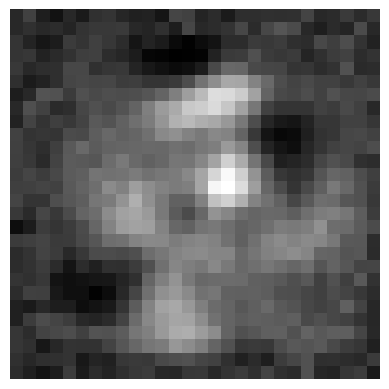

In [57]:
z = np.random.random((1, 32))
picture = autoencoder.decode(z)[0]

plt.imshow(picture, cmap="gray")
plt.axis("off")
plt.show()

In [ ]:
autoencoder = AutoEncoder(32)
autoencoder.compile(optimizer="rmsprop", loss="binary_crossentropy")

2023-08-24 15:44:31.303431: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


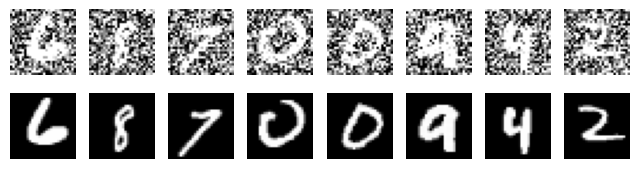

In [68]:
def encode(image):
    image = tf.image.convert_image_dtype(image, tf.float32)
    noise = tf.random.normal(
        shape=image.shape,
        mean=.5,
        stddev=.5,
        dtype=tf.float32
    )
    return tf.clip_by_value(image + noise, 0.0, 1.0), image

mnist_train = mnist_train_original.map(lambda image, _: encode(image)).cache().shuffle(6000)
mnist_validate = mnist_validate_original.map(lambda image, _: encode(image)).cache()
mnist_test  = mnist_test_original.map(lambda image, _: encode(image)).cache()

render_dataset()

In [70]:
_ = autoencoder.fit(
    mnist_train.batch(256),
    epochs=50,
    validation_data=mnist_validate.batch(256)
)

Epoch 1/50
  1/235 [..............................] - ETA: 6s - loss: 0.2445

235/235 [==============================] - 2s 8ms/step - loss: 0.2351 - val_loss: 0.2203
Epoch 2/50
235/235 [==============================] - 2s 8ms/step - loss: 0.2124 - val_loss: 0.2099
Epoch 3/50
235/235 [==============================] - 2s 8ms/step - loss: 0.2003 - val_loss: 0.1965
Epoch 4/50
235/235 [==============================] - 2s 8ms/step - loss: 0.1911 - val_loss: 0.1860
Epoch 5/50
235/235 [==============================] - 2s 8ms/step - loss: 0.1840 - val_loss: 0.1772
Epoch 6/50
235/235 [==============================] - 2s 8ms/step - loss: 0.1785 - val_loss: 0.1787
Epoch 7/50
235/235 [==============================] - 2s 8ms/step - loss: 0.1735 - val_loss: 0.1734
Epoch 8/50
235/235 [==============================] - 2s 8ms/step - loss: 0.1694 - val_loss: 0.1633
Epoch 9/50
235/235 [==============================] - 2s 8ms/step - loss: 0.1654 - val_loss: 0.1677
Epoch 10/50
235/235 [==============================] - 2s 8ms/step - loss: 0.1622 - val_loss: 0.1628
Epoch 11/5

# Varional AutoEncoder
- more info, [link](https://keras.io/examples/generative/vae/)

1/1 [==============================] - 0s 77ms/step
Model: "variational_auto_encoder_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_5 (Reshape)         (None, 784)               0         
                                                                 
 dense_12 (Dense)            (None, 256)               200960    
                                                                 
 dense_13 (Dense)            (None, 32)                8224      
                                                                 
 dense_14 (Dense)            multiple                  0 (unused)
                                                                 
 sampling_1 (Sampling)       (None, 32)                0         
                                                                 
 dense_15 (Dense)            (None, 256)               8448      
                                                      

2023-08-24 17:09:36.329988: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-08-24 17:09:36.330067: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


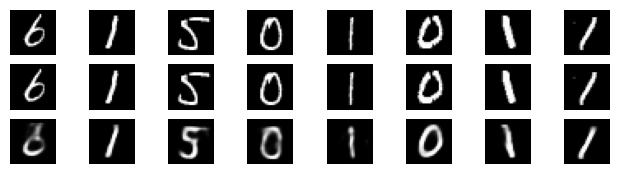

In [77]:
class VariationalAutoEncoder(tf.keras.Model):
    
    def __init__(self, latent_dim): # Constructor.
        super().__init__()

        self.latent_dim = latent_dim

        # Encoder.
        self.encoder_reshape = tf.keras.layers.Reshape((784,))
        self.encoder_fc1 = tf.keras.layers.Dense(256, activation="relu")
        self.encoder_fc_mean = tf.keras.layers.Dense(latent_dim, activation="linear")
        self.encoder_fc_logvar = tf.keras.layers.Dense(latent_dim, activation="linear")

        # Sampling
        self.sampling = Sampling()

        # Decoder.
        self.decoder_fc1 = tf.keras.layers.Dense(256, activation="relu")
        self.decoder_fc2 = tf.keras.layers.Dense(784, activation="sigmoid")
        self.decoder_reshape = tf.keras.layers.Reshape((28, 28, 1))

        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

        self._build_graph()

    def _build_graph(self):
        input_shape = (28, 28, 1)
        self.build((None,) + input_shape)
        inputs = tf.keras.Input(shape=input_shape)
        _ = self.call(inputs)

    def call(self, x):
        z_mean, z_logvar, z = self.encode(x)
        y = self.decode(z)
        return y

    def encode(self, x):
        #z = self.encoder_fc2(self.encoder_fc1(self.encoder_reshape(x)))
        z = self.encoder_reshape(x)
        z = self.encoder_fc1(z)
        z_mean = self.encoder_fc_mean(z)
        z_logvar = self.encoder_fc_mean(z)
        z = self.sampling([z_mean, z_logvar])
        return z_mean, z_logvar, z

    def decode(self, z):
        y = self.decoder_fc1(z)
        y = self.decoder_fc2(y)
        y = self.decoder_reshape(y)
        return y

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        data_input, data_output = data
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encode(data_input)
            reconstruction = self.decode(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.keras.losses.binary_crossentropy(data_output, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


autoencoder = VariationalAutoEncoder(32)
#autoencoder.summary()
prediction = autoencoder.predict(np.random.random((1, 28, 28, 1)))
autoencoder.summary()

autoencoder.compile(
    optimizer="adam",
    loss="binary_crossentropy"
)

def encode(image):
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image, image # input, output

mnist_train = mnist_train_original.map(lambda image, _: encode(image)).cache().shuffle(60000)
mnist_validate = mnist_validate_original.map(lambda image, _: encode(image)).cache()
mnist_test = mnist_test_original.map(lambda image, _: encode(image)).cache()

_ = autoencoder.fit(
    mnist_train.batch(256),
    epochs=50,
    #validation_data=mnist_validate.batch(256)
)

render_predictions()

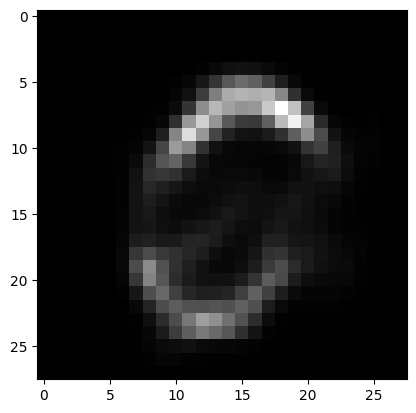

In [78]:
z = np.random.normal(0.0, 1.0, (1, 32))
picture = autoencoder.decode(z)[0]
plt.imshow(picture, cmap="gray")